# MMIK - lab 10: Algorytm Grovera

In [111]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

### 2 kubity - rozwiązanie z tutoriala

In [112]:
n = 2
grover_circuit = QuantumCircuit(n)

Stan splątany $|s\rangle$:

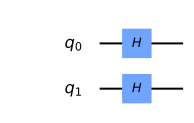

In [113]:
for qubit in range(n):
    grover_circuit.h(qubit)
grover_circuit.draw('mpl')

Wyrocznia dla stanu szukanego $|w\rangle = |00\rangle$:

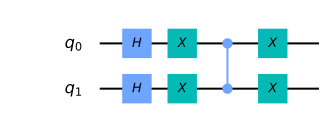

In [114]:
for qubit in range(n):
    grover_circuit.x(qubit)

grover_circuit.cz(0, 1)

for qubit in range(n):
    grover_circuit.x(qubit)

grover_circuit.draw('mpl')

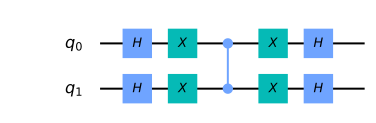

In [115]:
for qubit in range(n):
    grover_circuit.h(qubit)
grover_circuit.draw('mpl')

Inwersja $U_s$:

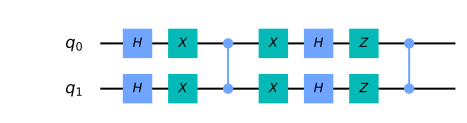

In [116]:
for qubit in range(n):
    grover_circuit.z(qubit)
grover_circuit.cz(0, 1)

grover_circuit.draw('mpl')

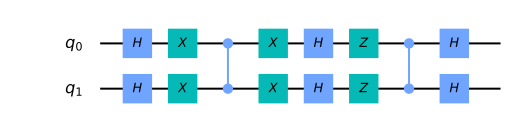

In [117]:
for qubit in range(n):
    grover_circuit.h(qubit)

grover_circuit.draw('mpl')

#### Eksperyment na symulatorze

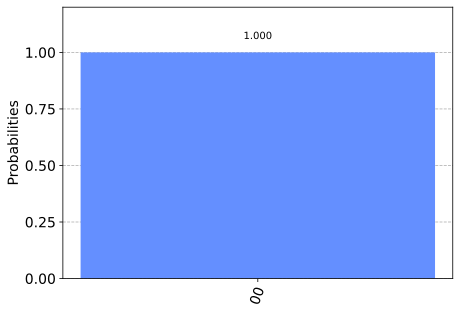

In [118]:
grover_circuit.measure_all()

backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

#### Eksperyment na prawdziwym komputerze kwantowym

In [119]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_burlington')

ibmqfactory.load_account:WARNING:2020-06-04 18:04:19,233: Credentials are already in use. The existing account in the session will be replaced.


In [120]:
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=backend, shots=1024)
job_monitor(job, interval = 2)

Job Status: job has successfully run


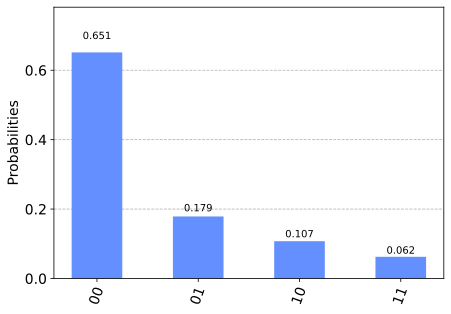

In [121]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

### Rozwiązanie "książkowe"

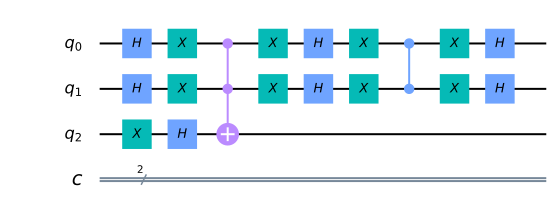

In [122]:
n = 2
grover_circuit = QuantumCircuit(n + 1, 2)
grover_circuit.x(2) # ustawiamy jedynkę na kubicie wyjściowym

for qubit in range(n + 1):
    grover_circuit.h(qubit)

for qubit in range(n):
    grover_circuit.x(qubit)

grover_circuit.ccx(0, 1, 2)

for qubit in range(n):
    grover_circuit.x(qubit)
    grover_circuit.h(qubit)
    grover_circuit.x(qubit)

grover_circuit.cz(0, 1)

for qubit in range(n):
    grover_circuit.x(qubit)
    grover_circuit.h(qubit)

grover_circuit.draw('mpl')

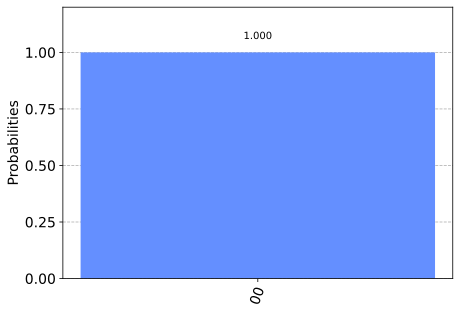

In [123]:
grover_circuit.measure([0, 1], [0, 1])

backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [125]:
backend = provider.get_backend('ibmq_burlington')
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=backend, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


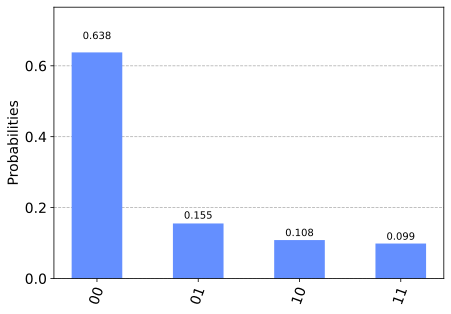

In [126]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

Porównanie wyników: W obu przypadkach wyraźnie został znaleziony oczekiwany stan |00>. W przypadku rozwiązania książkowego wynik jest odrobinę gorszy prawdopodobnie z powodu wykorzystania splątania pomiędzy trzema kubitami, co mogło zwiększyć szum.

### Rozwiązanie dla 3 kubitów (układ z tutoriala - szukamy dwóch stanów szczególnych):

Szukamy stanów |101> oraz |110>. Najpierw przeprowadźmy symulację, a następnie zobaczymy co się dzieje po przejściu przez kolejne bloki.

In [127]:
def phase_oracle(circuit):
    circuit.cz(0, 2)
    circuit.cz(1, 2)

In [128]:
def diffuser(circuit):
    """Apply inversion about the average step of Grover's algorithm."""
    qubits = circuit.qubits
    nqubits = len(qubits)
    
    for q in range(nqubits):
        circuit.h(q)
        circuit.x(q)
    
    # Do controlled-Z
    circuit.h(2)
    circuit.ccx(0,1,2)
    circuit.h(2)
    
    for q in range(nqubits):
        circuit.x(q)
        circuit.h(q)

In [129]:
n = 3
barriers = True

grover_circuit = QuantumCircuit(n)

for qubit in range(n):
    grover_circuit.h(qubit)

grover_circuit.barrier()

phase_oracle(grover_circuit)

grover_circuit.barrier()

diffuser(grover_circuit)

grover_circuit.measure_all()

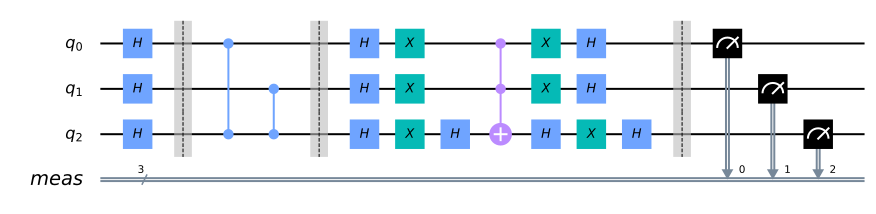

In [130]:
grover_circuit.draw(output="mpl")

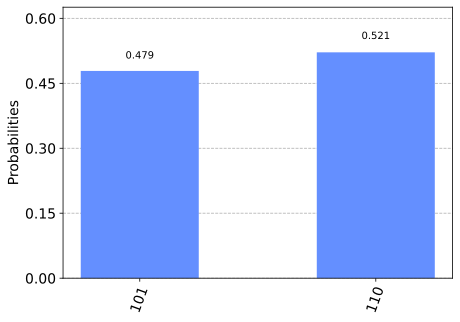

In [131]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Jak widać wzmocnione zostały dobre stany. Zobaczmy jak wyglądają amplitudy przed wyrocznią, po wyroczni oraz po inwersji:

In [132]:
backend = Aer.get_backend('statevector_simulator')

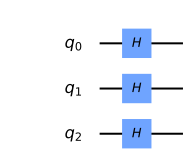

In [133]:
n = 3
barriers = True

grover_circuit = QuantumCircuit(n)

for qubit in range(n):
    grover_circuit.h(qubit)

grover_circuit.draw(output="mpl")

In [134]:
def print_state():
    job = execute(grover_circuit, backend)
    result = job.result()
    outputstate = result.get_statevector(grover_circuit, decimals=3)
    print(outputstate)
print_state()

[0.354+0.j 0.354+0.j 0.354+0.j 0.354+0.j 0.354+0.j 0.354+0.j 0.354+0.j
 0.354+0.j]


Jak widać wychodzimy od stanu splątanego, gdzie wszystkie amplitudy są sobie równe.

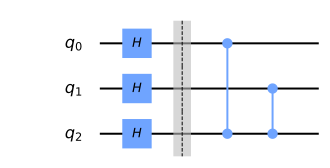

In [135]:
grover_circuit.barrier()
phase_oracle(grover_circuit)
grover_circuit.draw(output="mpl")

In [136]:
print_state()

[ 0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j -0.354+0.j
 -0.354+0.j  0.354+0.j]


Po przejściu przez wyrocznię wybrane stany zostały wyróżnione minusem.

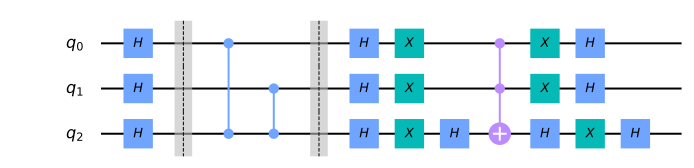

In [137]:
grover_circuit.barrier()
diffuser(grover_circuit)
grover_circuit.draw(output="mpl")

In [138]:
print_state()

[-0.   +0.j -0.   +0.j -0.   -0.j -0.   -0.j -0.   -0.j -0.707+0.j
 -0.707+0.j  0.   -0.j]


Po przejściu przez inwersję stany, które wcześniej miały minus, zostały wzmocnione, a pozostałe osłabione. Wystarczyła jedna iteracja aby maksymalnie wzmocnić i maksymalnie osłabić to co trzeba.